In [1]:
import TensorFlow
import Python

In [2]:
%include "PythonCheckpointReader.swift"

In [3]:
let reader = PythonCheckpointReader(path: "./vgg_16.ckpt")

In [4]:
let weightTensor = reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_1/weights")

Name: vgg_16/conv3/conv3_1/weights


In [5]:
print(weightTensor!.mean())

-0.00012589696


In [6]:
let biasTensor = reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_1/biases")

Name: vgg_16/conv1/conv1_1/biases


In [7]:
let fc6Weights = reader.readTensor(layerName: "vgg_16/fc6", weightName: "weights")

Name: vgg_16/fc6/weights


In [8]:
print(weightTensor!.shape)
print(biasTensor!.shape)
print(fc6Weights!.shape)

TensorShape(dimensions: [3, 3, 128, 256])
TensorShape(dimensions: [64])
TensorShape(dimensions: [7, 7, 512, 4096])


In [9]:
// let np = Python.import("numpy")

In [10]:
// var weights = np.load("./vgg16_weights.npz")
// let keys = Python.sorted(weights.keys())

In [11]:
// print(type(of: weights))

In [12]:
// for key in keys {
//     print(weights[key].shape)
// }

In [13]:
// let test = Tensor<Float>(numpy: weights["conv1_1_W"])!
// print(type(of: test))

In [84]:
public protocol FALayer: Layer {
    associatedtype Input
    associatedtype Output
    
    var delegate: LayerDelegate<Output> { get set }
    
    @differentiable
    func forward(_ input: Input) -> Output
    
}

public extension FALayer {
    
    @differentiable
    func applied(to input: Input, in context: Context) -> Output {
        let activation = forward(input)
        delegate.didProduceActivation(activation)
        return activation
    }
    
    @differentiable
    func call(_ input: Input) -> Output {
        let activation = forward(input)
        delegate.didProduceActivation(activation)
        return activation
    }
}

open class LayerDelegate<Output> {
    var lastActivation: Output
    public init(lastActivation: Output) {
        self.lastActivation = lastActivation
    }
    
    open func didProduceActivation(_ activation: Output) {}
}

In [85]:
@_fixed_layout
public struct FAConv2D<Scalar: TensorFlowFloatingPoint>: FALayer {
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    
    public var filter: Tensor<Scalar>
    public var bias: Tensor<Scalar>
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    @noDerivative public let activation: Activation
    @noDerivative public let strides: (Int32, Int32)
    @noDerivative public let padding: Padding
    
    @noDerivative public var delegate: LayerDelegate<Output> = LayerDelegate(lastActivation: Tensor<Scalar>(ones: [1]))

    public init(
        filter: Tensor<Scalar>,
        bias: Tensor<Scalar>,
        activation: @escaping Activation,
        strides: (Int32, Int32),
        padding: Padding
    ) {
        self.filter = filter
        self.bias = bias
        self.activation = activation
        self.strides = strides
        self.padding = padding
    }

    @differentiable
    public func forward(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return activation(input.convolved2D(withFilter: filter,
                                            strides: (1, strides.0, strides.1, 1),
                                            padding: padding) + bias)
    }
}

public extension FAConv2D {
    init<G: RandomNumberGenerator>(
        filterShape: (Int32, Int32, Int32, Int32),
        strides: (Int32, Int32) = (1, 1),
        padding: Padding = .valid,
        activation: @escaping Activation = identity,
        generator: inout G
    ) {
        let filterTensorShape = TensorShape([
            filterShape.0, filterShape.1,
            filterShape.2, filterShape.3])
        self.init(
            filter: Tensor(glorotUniform: filterTensorShape, generator: &generator),
            bias: Tensor(zeros: TensorShape([filterShape.3])),
            activation: activation,
            strides: strides,
            padding: padding)
    }
}

public extension FAConv2D {
    init(
        filterShape: (Int32, Int32, Int32, Int32),
        strides: (Int32, Int32) = (1, 1),
        padding: Padding = .valid,
        activation: @escaping Activation = identity,
        seed: (Int64, Int64) = (Int64.random(in: Int64.min..<Int64.max),
                                Int64.random(in: Int64.min..<Int64.max))
    ) {
        let filterTensorShape = TensorShape([
            filterShape.0, filterShape.1,
            filterShape.2, filterShape.3])
        self.init(
            filter: Tensor(glorotUniform: filterTensorShape, seed: seed),
            bias: Tensor(zeros: TensorShape([filterShape.3])),
            activation: activation,
            strides: (strides.0, strides.1),
            padding: padding)
    }
}

In [86]:
struct ImageTensorLayer: Layer {
    var imageTensor: Tensor<Float>
    
    init(imageTensor: Tensor<Float>) {
        self.imageTensor = imageTensor
    }
    
    @differentiable
    func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
        return self.imageTensor
    }
}

In [87]:
struct VGG16: Layer {
    var imageTensorLayer: ImageTensorLayer
    var conv1a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 3, 64), strides: (1, 1), padding: .same)
    var conv1b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 64, 64), strides: (1, 1), padding: .same)
    
    var conv2a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 64, 128), strides: (1, 1), padding: .same)
    var conv2b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 128, 128), strides: (1, 1), padding: .same)
    
    var conv3a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 128, 256), strides: (1, 1), padding: .same)
    var conv3b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 256, 256), strides: (1, 1), padding: .same)
    var conv3c: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 256, 256), strides: (1, 1), padding: .same)
    
    var conv4a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 256, 512), strides: (1, 1), padding: .same)
    var conv4b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
    var conv4c: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
    
    var conv5a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
    var conv5b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
    var conv5c: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
        
    var maxPool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool3 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool4 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool5 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    
    init(reader: PythonCheckpointReader,
         layerDelegates: [String: LayerDelegate<Tensor<Float>>],
        imageTensor: Tensor<Float>) {
        
        let strides = (Int32(1), Int32(1))
        
        self.imageTensorLayer = ImageTensorLayer(imageTensor: imageTensor)
        
        self.conv1a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv1a"] {
            print(delegate)
            self.conv1a.delegate = delegate
        }
        
        self.conv1b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same).withoutDerivative()
        
// Layer 2
        self.conv2a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv2", weightName: "conv2_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv2", weightName: "conv2_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv2a"] {
            print(delegate)
            self.conv2a.delegate = delegate
        }
        self.conv2b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv2", weightName: "conv2_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv2", weightName: "conv2_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
// Layer 3
        self.conv3a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv3a"] {
            print(delegate)
            self.conv3a.delegate = delegate
        }
        
        self.conv3b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        self.conv3c = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_3/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_3/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
// Layer 4
        self.conv4a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv4a"] {
            print(delegate)
            self.conv4a.delegate = delegate
        }
        
        self.conv4b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv4b"] {
            print(delegate)
            self.conv4b.delegate = delegate
        }
        
        self.conv4c = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_3/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_3/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
// Layer 5
        
        self.conv5a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv5a"] {
            print(delegate)
            self.conv5a.delegate = delegate
        }
        
        self.conv5b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        self.conv5c = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_3/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_3/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
    }
    
//     typealias Output = Tensor<Float>
    @differentiable
    func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
//         var activations = [String: Tensor<Float>]()
        var tmp = input
        
        tmp = imageTensorLayer.applied(to: tmp, in: context)
        // Layer 1
        tmp = conv1a.applied(to: tmp, in: context)
        tmp = conv1b.applied(to: tmp, in: context)
        tmp = maxPool1.applied(to: tmp, in: context)
        
        // Layer 2 
        tmp = conv2a.applied(to: tmp, in: context)
        tmp = conv2b.applied(to: tmp, in: context)
        tmp = maxPool2.applied(to: tmp, in: context)
        
        // Layer 3
        tmp = conv3a.applied(to: tmp, in: context)
        tmp = conv3b.applied(to: tmp, in: context)
        tmp = conv3c.applied(to: tmp, in: context)
        tmp = maxPool3.applied(to: tmp, in: context)
        
        // Layer 4
        tmp = conv4a.applied(to: tmp, in: context)
        tmp = conv4b.applied(to: tmp, in: context)
        tmp = conv4c.applied(to: tmp, in: context)
        tmp = maxPool4.applied(to:  tmp, in: context)
        
        // Layer 5
        tmp = conv5a.applied(to: tmp, in: context)
        tmp = conv5b.applied(to: tmp, in: context)
        tmp = conv5c.applied(to: tmp, in: context)
        tmp = maxPool5.applied(to: tmp, in: context)
        
        return tmp
    }
}

In [90]:
class Conv1aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
    }
}

class Conv2aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
    }
}

class Conv3aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
    }
}

class Conv4aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
    }
}

class Conv4bDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
    }
}

class Conv5aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
    }
}

let conv1aDelegate = Conv1aDelegate(lastActivation: Tensor<Float>(ones:[1]))
let conv2aDelegate = Conv2aDelegate(lastActivation: Tensor<Float>(ones:[1]))
let conv3aDelegate = Conv3aDelegate(lastActivation: Tensor<Float>(ones:[1]))
let conv4aDelegate = Conv4aDelegate(lastActivation: Tensor<Float>(ones:[1]))
let conv4bDelegate = Conv4bDelegate(lastActivation: Tensor<Float>(ones:[1]))
let conv5aDelegate = Conv5aDelegate(lastActivation: Tensor<Float>(ones:[1]))

let delegates = ["conv1a" : conv1aDelegate,
                 "conv2a" : conv2aDelegate,
                 "conv3a" : conv3aDelegate,
                 "conv4a" : conv4aDelegate,
                 "conv4b" : conv4bDelegate,
                 "conv5a" : conv5aDelegate]

In [91]:
// print(model.conv1a.filter.shape)
// print(model.conv1b.filter.shape)

// print(model.conv2a.filter.shape)
// print(model.conv2b.filter.shape)

// print(model.conv3a.filter.shape)
// print(model.conv3b.filter.shape)
// print(model.conv3c.filter.shape)

// print(model.conv4a.filter.shape)
// print(model.conv4b.filter.shape)
// print(model.conv4c.filter.shape)

// print(model.conv5a.filter.shape)
// print(model.conv5b.filter.shape)
// print(model.conv5c.filter.shape)

// print(model.fc1.weight.shape)
// print(model.fc2.weight.shape)
// print(model.fc3.weight.shape)

In [92]:
// print(model.fc3.weight)

In [93]:
let Image = Python.import("PIL.Image")

In [94]:
let np = Python.import("numpy")

In [95]:
func resizeImage(filename: StringTensor, size: (Int32, Int32)) -> Tensor<Float> {
    let imageBytes: StringTensor = Raw.readFile(filename: filename)
    let decodedImage = Raw.decodeJpeg(contents: imageBytes, channels: 3, dctMethod: "") 
    let resizedImages = Raw.resizeBicubic(
        images: Tensor<UInt8>([decodedImage]), 
        size: Tensor<Int32>([size.0, size.1]))
    return resizedImages.reshaped(to: TensorShape(size.0, size.1, 3))
}

In [96]:
let testImageTensor = resizeImage(filename: StringTensor("./puppy.jpg"), size: (224, 224))
let testStyleTensor = resizeImage(filename: StringTensor("./strokes.jpg"), size: (224, 224))

In [97]:
// Setup.
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [98]:
func showImageTensor(tensor: Tensor<Float>) {
    plt.imshow(Tensor<UInt8>(tensor).makeNumpyArray())
    plt.show()
}

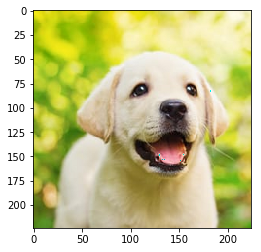

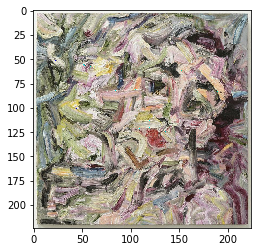

In [99]:
showImageTensor(tensor: testImageTensor)
showImageTensor(tensor: testStyleTensor)

In [100]:
// TF Format: NHWC
// PIL Format: WHC
let mean = Tensor<Float>([103.939, 116.78, 123.68])
let std  = Tensor<Float>([0.229, 0.224, 0.225])
let normalizedImage = ((testImageTensor) - mean)
let normalizedStyle = ((testStyleTensor) - mean)
let testImageBatch = normalizedImage.expandingShape(at: 0)
let testStyleBatch = normalizedImage.expandingShape(at: 0)

In [101]:
print(testImageBatch.shape)

TensorShape(dimensions: [1, 224, 224, 3])


In [102]:
var model = VGG16(reader: reader, layerDelegates: delegates, imageTensor: testImageBatch)

Name: vgg_16/conv1/conv1_1/weights
Name: vgg_16/conv1/conv1_1/biases
__lldb_expr_513.Conv1aDelegate
Name: vgg_16/conv1/conv1_2/weights
Name: vgg_16/conv1/conv1_2/biases
Name: vgg_16/conv2/conv2_1/weights
Name: vgg_16/conv2/conv2_1/biases
__lldb_expr_513.Conv2aDelegate
Name: vgg_16/conv2/conv2_2/weights
Name: vgg_16/conv2/conv2_2/biases
Name: vgg_16/conv3/conv3_1/weights
Name: vgg_16/conv3/conv3_1/biases
__lldb_expr_513.Conv3aDelegate
Name: vgg_16/conv3/conv3_2/weights
Name: vgg_16/conv3/conv3_2/biases
Name: vgg_16/conv3/conv3_3/weights
Name: vgg_16/conv3/conv3_3/biases
Name: vgg_16/conv4/conv4_1/weights
Name: vgg_16/conv4/conv4_1/biases
__lldb_expr_513.Conv4aDelegate
Name: vgg_16/conv4/conv4_2/weights
Name: vgg_16/conv4/conv4_2/biases
__lldb_expr_513.Conv4bDelegate
Name: vgg_16/conv4/conv4_3/weights
Name: vgg_16/conv4/conv4_3/biases
Name: vgg_16/conv5/conv5_1/weights
Name: vgg_16/conv5/conv5_1/biases
__lldb_expr_513.Conv5aDelegate
Name: vgg_16/conv5/conv5_2/weights
Name: vgg_16/conv5/c

In [103]:
let context = Context(learningPhase: .inference)
let logits = model.applied(to: testStyleBatch, in: context)

In [104]:
// [[[[          0.0,      90.09491,    0.16655076, ...,           0.0,     10.285216,

In [106]:
var act = model.conv1a.delegate.lastActivation
print(act.shape)

TensorShape(dimensions: [1, 224, 224, 64])


In [107]:
let reshaped = act.reshaped(to: TensorShape(act.shape[0], 
                                act.shape[1] * act.shape[2], 
                                act.shape[3])).squeezingShape(at: 0)
print(reshaped.shape)
print(reshaped.transposed().shape)
print(( reshaped.transposed() • reshaped ).shape)

TensorShape(dimensions: [50176, 64])
TensorShape(dimensions: [64, 50176])
TensorShape(dimensions: [64, 64])


In [108]:
func gramProduct(of tensor: Tensor<Float>) -> Tensor<Float> {
    let flatActivation = tensor.reshaped(to: TensorShape(tensor.shape[0], 
                                                         tensor.shape[1] * tensor.shape[2], 
                                                         tensor.shape[3])).squeezingShape(at: 0)
    
    let actTransposed = flatActivation.transposed()
    
    print("act: \(flatActivation.shape) act.t: \(actTransposed.shape)")
    var gram = actTransposed • flatActivation
    gram =  gram / Float(tensor.shape[1] * tensor.shape[2])
    return gram
}

In [109]:
let actGram = gramProduct(of: act)

act: TensorShape(dimensions: [50176, 64]) act.t: TensorShape(dimensions: [64, 50176])


In [110]:
print(actGram)

[[    1326.5538,    0.09549093,      628.0849, ...,     315.78033,      550.5934,
       764.9562],
 [   0.09549093,   0.017772509,    0.07796878, ...,           0.0,    0.20676465,
     0.16820839],
 [     628.0849,    0.07796878,     1399.1676, ...,      91.95782,     557.53094,
      851.33105],
 ...,
 [    315.78033,           0.0,      91.95782, ...,     2500.6707,     268.69855,
      208.68738],
 [     550.5934,    0.20676465,     557.53094, ...,     268.69855,     1101.3185,
       890.8391],
 [     764.9562,    0.16820839,     851.33105, ...,     208.68738,      890.8391,
      961.60986]]


In [111]:
for kp in model.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
    print(model[keyPath: kp])
}

[[[[      138.061,        115.22,       -100.68],
   [    138.28757,     115.44656,    -100.90656],
   [      139.436,     116.31375,       -101.68],
   ...,
   [    145.25241,     128.44656,      84.47625],
   [      146.561,        129.22,         87.82],
   [     147.8696,     129.99344,      91.26922]],

  [[    138.28757,     115.44656,    -100.90656],
   [    138.45358,    115.612595,   -101.090996],
   [    138.83286,     115.77432,    -102.19819],
   ...,
   [    142.73761,     125.71373,     79.797066],
   [    144.61667,     127.54544,     82.087456],
   [     145.9144,     128.92087,       83.5568]],

  [[    139.15475,     116.31375,    -101.96125],
   [    139.78622,     116.94522,    -101.24482],
   [    139.38718,     116.56375,    -101.31867],
   ...,
   [    138.62558,    122.209625,      68.01678],
   [     141.6528,    124.247345,     72.710625],
   [    144.65329,     127.40933,     75.861626]],

  ...,

  [[   -24.903847,     13.149689,     -98.50422],
   [   -24.9

[[[[  -0.0023012366,    -0.005891813,     0.003965236, ...,   0.00086993474,
        0.004312571,    0.0023981535],
   [    0.006934559,    0.0017766978,      0.01871946, ...,    -0.031739756,
       -0.004214422,    -0.017630888],
   [    -0.01279008,    -0.006507808,   -0.0041028643, ...,    0.0023148265,
       -0.046782266,    -0.003756684],
   ...,
   [ -0.00047528607,    -0.029628353,     0.030353852, ...,     0.001516485,
       -0.027169585,   -0.0018443057],
   [    0.014174322,   -0.0003644809,   -0.0023375428, ...,    -0.022823773,
       -0.016001485,     0.024663102],
   [    0.011860821,    -0.027720047,    -0.024860684, ...,       0.0410957,
         0.05570638,    -0.021931699]],

  [[   -0.001382946,    -0.005546907,   -0.0010613843, ...,    0.0018225099,
     -0.00035901595,     0.009999242],
   [   0.0067560147,    0.0011039012,     0.021863759, ...,     -0.03564092,
      -0.0024502694,   -0.0060440707],
   [   -0.013580485,    -0.008606096,      0.01281111, ...,   

[[[[    0.002486315,    0.0032909603,     -0.03130716, ...,    0.0047185165,
       0.0006100464,     0.010805934],
   [    0.013604028,    0.0038090614,    -0.035043806, ...,     0.008503655,
       0.0049989447,   0.00024537373],
   [   -0.010296034,     0.011104525,     -0.01055603, ...,     0.011811925,
       0.0041463017,     0.010499414],
   ...,
   [   0.0021405031,      0.00217349,    -0.040928338, ...,    -0.008341894,
        0.023573859,    -0.018547183],
   [    0.016126163,    8.047426e-05,       -0.039527, ...,   -0.0039445353,
        0.008420309,  -0.00069804006],
   [  -0.0035146575,     0.010831606,    -0.022383004, ...,     0.019215534,
       0.0042197295,     -0.01557073]],

  [[    0.006110936,     0.005448228,     0.015754184, ...,    0.0056078187,
        0.001939789,     0.014920237],
   [   -0.031342603,     0.014571885,     0.011874451, ...,     0.012186357,
        0.014944316,    0.0026073018],
   [   -0.023227591,     0.020891115,     0.011153726, ...,   

[[[[  -0.0103266295,   -0.0025765933,   0.00023916765, ...,   -0.0011899866,
       -0.009755479,   -0.0024732405],
   [   -0.009870347,   -0.0018885288,   0.00027566744, ...,    -0.009986935,
       -0.005982588,     0.004409063],
   [    0.016183563,    -0.009380578,   -0.0067340597, ...,   -0.0024240117,
       0.0109589035,     0.013916721],
   ...,
   [   -0.014017665,   -0.0030881169,    0.0034150223, ...,     0.005332489,
        -0.01703558,    -0.013635924],
   [   0.0017419365,    -0.009952344,  -0.00043590346, ...,   -0.0024184096,
       -0.016855573,     0.010546397],
   [  -0.0047730976,   -0.0066677653,    0.0050712666, ...,   -0.0012052676,
       0.0035555772,    0.0011733016]],

  [[  -0.0066428566,   -0.0034788128,    0.0023919009, ...,   -0.0075390637,
      -0.0057204543,    -0.009248385],
   [  -0.0029728797,    0.0033452115,   -0.0031863037, ...,    -0.011562368,
       -0.007907912,    0.0059265853],
   [    0.025377741,    0.0025328642,     0.021770779, ...,   

[[[[   0.0024918285,    -0.008250672,   -0.0013446122, ...,     0.008611671,
      -0.0037378082,    0.0006454999],
   [   -0.004425672,  -1.8835079e-05,    -0.017478913, ...,    -0.017407594,
       -0.002413879,   -0.0024544687],
   [   -0.014542272,     0.006534893,      0.04290568, ...,    0.0023287237,
       -0.008225609,    -0.013495141],
   ...,
   [    0.008144308,     0.004648008,      0.01786484, ...,    0.0013002226,
       -0.010230383,    -0.008594417],
   [  -0.0012571752,  -0.00041668423,    -0.005345987, ...,    -0.014315682,
       -0.005265161,   -0.0019292701],
   [    0.007583343,   0.00030368776,    0.0017679861, ...,   -0.0063041635,
      0.00054136076,   -0.0020875747]],

  [[    0.000562601,    -0.015745806,    -0.001899781, ...,    0.0037466455,
      -0.0007809313,     0.007869098],
   [   -0.009079944,    -0.001880952,    -0.010837484, ...,    0.0032520106,
       -0.008604073,    -0.010635252],
   [  -0.0102429595,     0.008975913,     0.020379672, ...,   

[[[[   -0.012453815,      0.00840656,   -0.0052884505, ...,    -0.002045819,
      -0.0039235945,    0.0013068381],
   [     0.01155669,    0.0024605596,     -0.04090826, ...,   -0.0049206265,
      -0.0016342339,     0.008942307],
   [ -0.00014346992,    -0.005658732,     0.018406698, ...,   -0.0020884068,
      2.6332182e-06,    -0.025072826],
   ...,
   [    0.013788823,    -0.006581802,     0.009653703, ...,    0.0071761045,
       0.0034572545,      0.00533174],
   [   0.0026583332,   0.00077770464,   0.00028623934, ...,   -0.0054058307,
        0.008931197,     0.014004302],
   [   -0.008539331,    0.0014339479,   -0.0029187903, ...,    0.0037766052,
        0.020545458,    -0.013586803]],

  [[   -0.012017647,    0.0015125084,    0.0034313013, ...,     -0.01578307,
        -0.00239501,     0.002935735],
   [     0.01071678,    -0.001728859,    -0.018321734, ...,     -0.00387932,
       -0.017472282,     0.003094059],
   [  -0.0027881276,     0.010900215,    0.0073146983, ...,   

[[[[    0.007116542,   7.0081906e-06,     0.009247005, ...,    0.0040392973,
        0.008055615,   -0.0037424571],
   [   0.0011278111,    0.0016153291,  -0.00090826757, ...,    -0.007937901,
      -0.0045909598,  -0.00081346487],
   [  -0.0046378924,    -0.011872724,     0.006585297, ...,    0.0074209166,
        -0.00653813,   -0.0024208624],
   ...,
   [   0.0012806368,    0.0014981931,    0.0072866827, ...,   -0.0059984187,
      -0.0020115147,   -0.0011838648],
   [    -0.00489709,   -0.0062694685,   -0.0050971434, ...,    0.0012690506,
       0.0107506765,   -0.0024421078],
   [   0.0021257051,   -0.0036131833,    -0.007264817, ...,   0.00036481742,
        0.015078726,    0.0041070357]],

  [[   0.0066426997,   -0.0060184053,      0.00942178, ...,     0.004534539,
       0.0004712068,     0.003508966],
   [   -0.012412882,    0.0016226519,   2.1841019e-05, ...,    -0.009268283,
       -0.013272022,     0.007849746],
   [   -0.002277501,    -0.013785151,     0.006047731, ...,   

[[[[  -0.0041355654,     0.007471954,    -0.003501159, ...,    4.898543e-06,
      -0.0025383946,   -0.0052532647],
   [   -0.009538344,    0.0014105609,    -0.016544206, ...,   -0.0015277497,
       0.0011103683,   -0.0017978617],
   [  -0.0035196797,      0.00838234,    0.0013701437, ...,    -0.002043623,
       -0.003330984,   -0.0035916462],
   ...,
   [   -0.004514204,     -0.00990713,    -0.007901194, ...,  -0.00027418195,
      0.00080459216,      -0.0092149],
   [   0.0041336203,    0.0016450328,   -0.0012485307, ...,  -0.00048008596,
       0.0014360374,   -0.0023793117],
   [   -0.009460639,   -0.0030288189,  -0.00039379316, ...,   -0.0083740465,
      -0.0008497214,    0.0021901021]],

  [[   -0.004104465,   -0.0015482415,   -0.0054187565, ...,   -0.0022412997,
      -0.0022859687,    -0.003348583],
   [  -0.0048478767,    0.0024720116,    -0.012987968, ...,     0.008189966,
       -0.004545886,     0.009626442],
   [  -0.0031020553,    0.0034790197,     0.002520363, ...,   

[[[[  -0.0006068934,    0.0014231558,    0.0073316055, ...,    0.0026178278,
      0.00043357504,   -0.0029434897],
   [  -0.0048605306,   0.00049075234,   -0.0012511463, ...,    0.0011560039,
      -0.0001268371,    -0.015934335],
   [   0.0082136225,     0.007496725,    0.0044443067, ...,    -0.010573096,
       -0.013803735,   -0.0020028956],
   ...,
   [    0.002023448,    -0.005838034,    -0.002382585, ...,    0.0013192679,
       -0.008692045,   -0.0008215642],
   [    0.007941416,    -0.008008698,   0.00077348115, ...,     0.009101409,
      0.00068836473,    -0.009863088],
   [   0.0073094536,   -0.0011607672,    0.0051686643, ...,   -0.0018046533,
      -7.711175e-05,    0.0035778836]],

  [[  -0.0015249068,   -0.0031574788,     0.004557122, ...,    -0.008163467,
       -0.008150073,   -0.0058323247],
   [  -0.0012195857,   -0.0054482273,    -0.008493981, ...,    0.0013417795,
      -0.0013884302,     -0.01670745],
   [   -0.002963559,     0.006936911,     0.005603041, ...,   

[[[[  -0.0011261065,    -0.013910273,   -0.0004152919, ...,   -0.0023909027,
        0.005594182,       -0.016781],
   [    0.011381389,  -0.00068303396,    -0.008769769, ...,    -0.008441519,
      -0.0037061004,     0.012489425],
   [   0.0021897112,    0.0017671135,     0.012396773, ...,     0.013455559,
       0.0107239345,    0.0057248017],
   ...,
   [   -0.008707695,     0.004261631,    -0.007062446, ...,     0.015485149,
        0.004638372,     0.007845004],
   [  -0.0006564853,    0.0076888907,   -0.0014529829, ...,   -0.0073500522,
      -0.0003104191,     0.008477414],
   [    0.005956649,      -0.0032758,   -0.0053211637, ...,   -0.0020393697,
       0.0013586589,    0.0059190476]],

  [[   0.0021276951,   -0.0051481104,   -0.0056224335, ...,    -0.013113426,
       0.0048886565,    -0.010150007],
   [    0.011701679,   -0.0071512037,    -0.008392449, ...,    -0.006675863,
      -0.0051041027,     0.014347731],
   [   0.0014326117,     0.021248473,     0.009502004, ...,   

[[[[  0.00040788297,     0.004826212,     -0.00911695, ...,     0.015156991,
      -0.0027396684,    -0.004833114],
   [   0.0034892405,    0.0026058974,    -0.008101989, ...,   0.00088698755,
      -0.0070823887,   -0.0007963212],
   [   -0.011275903,   -0.0064383675,    -0.008052368, ...,    0.0019041052,
       0.0038762712,      0.01963384],
   ...,
   [   -0.014994932,     0.012031826,    0.0009872367, ...,   -0.0028986104,
       0.0040331557,   -0.0059342934],
   [   -0.007533367,     0.006085306,    0.0009900143, ...,   0.00016324305,
      -0.0030962178,   -0.0030180835],
   [   -0.002625229,    0.0035188743,    -0.002583098, ...,    -0.006020275,
       -0.008850358,    0.0009858251]],

  [[  0.00030284608,     0.002647362,   -0.0137099335, ...,     0.014913519,
     -0.00046566623,    -0.006848987],
   [   -0.009601176,    0.0050103143,    -0.011305319, ...,     0.008867077,
        0.006212241,    0.0024888257],
   [   -0.011349934,    -0.004722855,    -0.008579032, ...,   

In [112]:
print(testImageBatch)

[[[[      138.061,        115.22,       -100.68],
   [    138.28757,     115.44656,    -100.90656],
   [      139.436,     116.31375,       -101.68],
   ...,
   [    145.25241,     128.44656,      84.47625],
   [      146.561,        129.22,         87.82],
   [     147.8696,     129.99344,      91.26922]],

  [[    138.28757,     115.44656,    -100.90656],
   [    138.45358,    115.612595,   -101.090996],
   [    138.83286,     115.77432,    -102.19819],
   ...,
   [    142.73761,     125.71373,     79.797066],
   [    144.61667,     127.54544,     82.087456],
   [     145.9144,     128.92087,       83.5568]],

  [[    139.15475,     116.31375,    -101.96125],
   [    139.78622,     116.94522,    -101.24482],
   [    139.38718,     116.56375,    -101.31867],
   ...,
   [    138.62558,    122.209625,      68.01678],
   [     141.6528,    124.247345,     72.710625],
   [    144.65329,     127.40933,     75.861626]],

  ...,

  [[   -24.903847,     13.149689,     -98.50422],
   [   -24.9

In [113]:
func zeroTensor(tensor: Tensor<Float>) -> Tensor<Float> {
    return Tensor<Float>(zeros: tensor.shape)
}

/// Adam optimizer.
///
/// Reference: ["Adam - A Method for Stochastic Optimization"](
/// https://arxiv.org/abs/1412.6980v8)
public class ImageAdam<Model: Layer>: Optimizer
    where Model.AllDifferentiableVariables == Model.CotangentVector {
    /// The learning rate.
    public var learningRate: Float
    /// A coefficient used to calculate the first and second moments of
    /// gradients.
    public var beta1: Float
    /// A coefficient used to calculate the first and second moments of
    /// gradients.
    public var beta2: Float
    /// A small scalar added to the denominator to improve numerical stability.
    public var epsilon: Float
    /// The weight decay.
    public var decay: Float
    /// The current step.
    public var step: Int = 0
    /// The first moments of the weights.
    public var firstMoments: Model.AllDifferentiableVariables
    /// The second moments of the weights.
    public var secondMoments: Model.AllDifferentiableVariables

    public init(
        for model: __shared Model,
        learningRate: Float = 1e-3,
        beta1: Float = 0.9,
        beta2: Float = 0.999,
        epsilon: Float = 1e-8,
        decay: Float = 0
    ) {
        precondition(learningRate >= 0, "Learning rate must be non-negative")
        precondition(0 <= beta1 && beta1 <= 1, "Beta parameter must be between 0 and 1")
        precondition(0 <= beta2 && beta2 <= 1, "Beta parameter must be between 0 and 1")
        precondition(decay >= 0, "Weight decay must be non-negative")

        self.learningRate = learningRate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.decay = decay

        // Initialize first & second moments to be zeros of the same shape.
        // We can't use `Model.AllDifferentiableVariables.zero` due to the
        // interaction between Key Paths and Differentiable Arrays.
        firstMoments = model.allDifferentiableVariables
        secondMoments = model.allDifferentiableVariables
        for kp in firstMoments.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
            firstMoments[keyPath: kp] = zeroTensor(tensor: firstMoments[keyPath: kp])
            secondMoments[keyPath: kp] = zeroTensor(tensor: secondMoments[keyPath: kp])
        }
    }


    public func update(_ model: inout Model.AllDifferentiableVariables,
                       along direction: Model.AllDifferentiableVariables) {
        step += 1
        let learningRate = self.learningRate * 1 / (1 + decay * Float(step))
        let stepSize = learningRate * (sqrt(1 - pow(beta2, Float(step))) /
            (1 - pow(beta1, Float(step))))
        // Update Float & Double Tensor variables.
        for kp in model.recursivelyAllWritableKeyPaths(to: Tensor<Float>.self) {
            firstMoments[keyPath: kp] =
                firstMoments[keyPath: kp] * beta1 + (1 - beta1) * direction[keyPath: kp]
            secondMoments[keyPath: kp] =
                secondMoments[keyPath: kp] * beta2 + (1 - beta2) *
                direction[keyPath: kp] * direction[keyPath: kp]
            model[keyPath: kp] -=
                stepSize * firstMoments[keyPath: kp] / (sqrt(secondMoments[keyPath: kp]) + epsilon)
            break
        }
    }
}

In [114]:
var noiseImage = Tensor<Float>(randomUniform: testImageBatch.shape) * 255.0

In [115]:
print(noiseImage.mean())

127.32542


In [116]:
print(noiseImage.squeezingShape(at: 0).shape)

TensorShape(dimensions: [224, 224, 3])


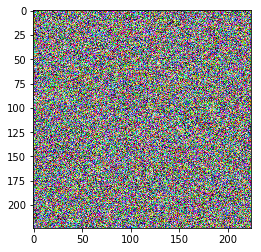

In [117]:
showImageTensor(tensor: noiseImage.squeezingShape(at: 0))

In [118]:
let optModel = VGG16(reader: reader, layerDelegates: delegates, imageTensor: noiseImage)

Name: vgg_16/conv1/conv1_1/weights
Name: vgg_16/conv1/conv1_1/biases
__lldb_expr_513.Conv1aDelegate
Name: vgg_16/conv1/conv1_2/weights
Name: vgg_16/conv1/conv1_2/biases
Name: vgg_16/conv2/conv2_1/weights
Name: vgg_16/conv2/conv2_1/biases
__lldb_expr_513.Conv2aDelegate
Name: vgg_16/conv2/conv2_2/weights
Name: vgg_16/conv2/conv2_2/biases
Name: vgg_16/conv3/conv3_1/weights
Name: vgg_16/conv3/conv3_1/biases
__lldb_expr_513.Conv3aDelegate
Name: vgg_16/conv3/conv3_2/weights
Name: vgg_16/conv3/conv3_2/biases
Name: vgg_16/conv3/conv3_3/weights
Name: vgg_16/conv3/conv3_3/biases
Name: vgg_16/conv4/conv4_1/weights
Name: vgg_16/conv4/conv4_1/biases
__lldb_expr_513.Conv4aDelegate
Name: vgg_16/conv4/conv4_2/weights
Name: vgg_16/conv4/conv4_2/biases
__lldb_expr_513.Conv4bDelegate
Name: vgg_16/conv4/conv4_3/weights
Name: vgg_16/conv4/conv4_3/biases
Name: vgg_16/conv5/conv5_1/weights
Name: vgg_16/conv5/conv5_1/biases
__lldb_expr_513.Conv5aDelegate
Name: vgg_16/conv5/conv5_2/weights
Name: vgg_16/conv5/c

In [120]:
let optimizer = ImageAdam(for: optModel, learningRate: 5)

In [121]:
let (loss, gradients) = valueWithGradient(at: optModel) { optModel -> Tensor<Float> in
    optModel.applied(to: noiseImage, in: Context(learningPhase: .training))
    let curAct = optModel.conv4b.delegate.lastActivation
    let targetAct = model.conv4b.delegate.lastActivation
    return meanSquaredError(predicted: curAct, expected: targetAct)
}

In [123]:
print(optModel.conv4b.delegate.lastActivation)

[[[[         0.0,    367.36618,    117.59673, ...,     540.2156,    152.74945,
             0.0],
   [         0.0,     429.1655,          0.0, ...,     83.29023,    12.221213,
             0.0],
   [         0.0,    275.29037,          0.0, ...,     77.10779,          0.0,
             0.0],
   ...,
   [         0.0,    202.23775,          0.0, ...,    128.67207,    247.79663,
             0.0],
   [         0.0,     403.7551,          0.0, ...,     532.1586,     394.2544,
             0.0],
   [         0.0,    659.87665,          0.0, ...,    979.69183,    1030.8405,
             0.0]],

  [[         0.0,          0.0,          0.0, ...,    197.46509,          0.0,
             0.0],
   [         0.0,          0.0,          0.0, ...,          0.0,          0.0,
             0.0],
   [         0.0,          0.0,          0.0, ...,          0.0,          0.0,
             0.0],
   ...,
   [         0.0,          0.0,          0.0, ...,          0.0,          0.0,
             0.0],
  

In [124]:
print(model.conv4b.delegate.lastActivation)

[[[[         0.0,    367.36618,    117.59673, ...,     540.2156,    152.74945,
             0.0],
   [         0.0,     429.1655,          0.0, ...,     83.29023,    12.221213,
             0.0],
   [         0.0,    275.29037,          0.0, ...,     77.10779,          0.0,
             0.0],
   ...,
   [         0.0,    202.23775,          0.0, ...,    128.67207,    247.79663,
             0.0],
   [         0.0,     403.7551,          0.0, ...,     532.1586,     394.2544,
             0.0],
   [         0.0,    659.87665,          0.0, ...,    979.69183,    1030.8405,
             0.0]],

  [[         0.0,          0.0,          0.0, ...,    197.46509,          0.0,
             0.0],
   [         0.0,          0.0,          0.0, ...,          0.0,          0.0,
             0.0],
   [         0.0,          0.0,          0.0, ...,          0.0,          0.0,
             0.0],
   ...,
   [         0.0,          0.0,          0.0, ...,          0.0,          0.0,
             0.0],
  